# INTRODUCTION


In the previous notebook we learned about FastNeuralStyleTransferNetwork. But as we have learned it has several limitations. One of the limitations is that it only works for one style. Meaning it can transfer any content image to only one single style the model was trained with and if we wanted to style the content image in a different style we would need to train a new model. 

In this notebook we will implement an Arbitary Style Transfer model which stylize a content image given any style image. Specifically we will try to implement [Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization](https://arxiv.org/abs/1703.06868) by Xun Huang et al. A lot of the code was taken from this [pytorch-AdaIN](https://github.com/naoto0804/pytorch-AdaIN) repo. 

<br>

***Prerequisites:***
<br>
* Basic Python & Pytorch
* Familiar with neural style transfer
<br>


***NOTE:*** This notebook is a continuation of my [previous notebook](https://github.com/shoabahamed/Nueral-Style-Transfer-Models/blob/master/faststyleneuralstyletransfer.ipynb) on fast style neural style transfer. so it is recomended that you check that out first if you are not familiar with neural style transfer. Since it is already 3d notebook of the series I will skip a lot of the obious stuff from now on

# LIBRARIES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset, RandomSampler


from torchvision import datasets
import torchvision.transforms.v2 as T
from torchvision import models
from torchvision.utils import make_grid, save_image


import os
import time
import random
from tqdm.notebook import tqdm
from path import Path

%matplotlib inline

# CONFIGURATIONS 

In [2]:
class CFG:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    batch_size = 8
    max_iterations = 160000
    learning_rate=1e-4
    lr_decay=5e-5
    
    style_dataset_path="/kaggle/input/wikiart"
    train_content_path="/kaggle/input/coco-2014-dataset-for-yolov3/coco2014/images/train2014"
    valid_content_path="/kaggle/input/coco-2014-dataset-for-yolov3/coco2014/images/val2014"
    encoder_path="/kaggle/input/style-transfer-models/pytorch/default/7/pretrained/vgg19-encoder/vgg_normalised_conv4_1.pth"
    trained_checkpoint_model = "/kaggle/input/style-transfer-models/pytorch/default/7/trained/ArbitaryStyleTransfer/adain_trained_decoder_110000.pth"
    
    
    train_model = False # set it to true to train the model from scratch
    seed = 42
    
    
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  
    

    
seed_everything(CFG.seed) # this function does note effect everyting globally

In [3]:
def show_images(images, labels, rows=2, figsize=(12, 5), title=""):
    """
    plot images of shape (B, C, H, W)
    
    images: (B, C, H, W)
    labels: List of strings
    """
    images = images.permute(0, 2, 3, 1).detach().cpu()  
    images = images.numpy()
    cols = max(1, len(images) // rows)
        
    if (rows, cols) == (1, 1):
        plt.figure(figsize=figsize)
        plt.imshow(images[0])
        plt.title(labels[0])
        plt.axis('off')
    else:
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        axes = axes.flatten()
        for img, label, ax in zip(images, labels, axes):
            ax.imshow(img)
            ax.set_title(f'{label}')
            ax.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()    
    

# DATASET AND DATALOADERS

In [4]:
class FlatFolderDataset(Dataset):
    def __init__(self, paths, transform):
        super(FlatFolderDataset, self).__init__()
        self.paths = paths
        self.transform = transform

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(str(path)).convert('RGB')
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.paths)

    def name(self):
        return 'FlatFolderDataset'


In [5]:
def get_style_paths(style_path, train_size):
    style_dirs = list(Path(style_path).glob('*'))
    style_paths = []
    for style_dir in style_dirs:
        style_paths.extend(style_dir.glob("*"))
        
    train_size = int(len(style_paths) * train_size)
    train_style_paths, valid_style_paths = style_paths[:train_size], style_paths[train_size:]
    return train_style_paths, valid_style_paths 

def get_paths(content_train_path, content_valid_path, style_path, style_train_size=0.95):
    train_content_paths = list(Path(content_train_path).glob('*'))
    valid_content_paths = list(Path(content_valid_path).glob('*'))
    train_style_paths, valid_style_paths = get_style_paths(style_path, style_train_size)

    return train_content_paths, train_style_paths, valid_content_paths, valid_style_paths

In [6]:
# transformations
def get_transform(train, img_size=None):
    transforms = []
    if img_size:
        transforms.append(T.Resize(size=img_size))
        
    if train:
        transforms.append(T.RandomCrop(size=(256, 256)))
        
    transforms.append(T.ToImage())
    transforms.append(T.ToDtype(torch.float32, scale=True))
    transforms.append(T.ToPureTensor())

    
    return T.Compose(transforms)

In [7]:
train_content_paths, train_style_paths, valid_content_paths, valid_style_paths = get_paths(CFG.train_content_path, CFG.valid_content_path, CFG.style_dataset_path)

train_transform = get_transform(train=True, img_size=512)
valid_transform = get_transform(train=False, img_size=(256, 256))


train_content_dataset = FlatFolderDataset(train_content_paths, train_transform)
train_style_dataset = FlatFolderDataset(train_style_paths, train_transform)
valid_content_dataset = FlatFolderDataset(valid_content_paths, valid_transform)
valid_style_dataset = FlatFolderDataset(valid_style_paths, valid_transform)


train_content_dataloader = DataLoader(train_content_dataset, batch_size=CFG.batch_size, shuffle=True, pin_memory=True, drop_last=True)
train_style_dataloader = DataLoader(train_style_dataset, batch_size=CFG.batch_size, shuffle=True, pin_memory=True,  drop_last=True)
valid_content_dataloader = DataLoader(valid_content_dataset, batch_size=CFG.batch_size, shuffle=True, pin_memory=True)
valid_style_dataloader = DataLoader(valid_style_dataset, batch_size=CFG.batch_size, shuffle=True, pin_memory=True)

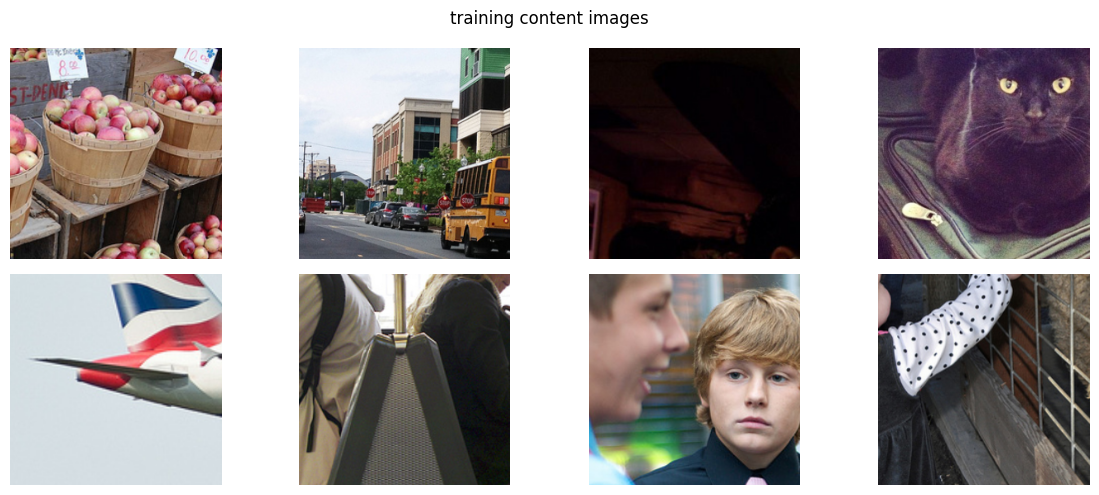

In [8]:
images = next(iter(train_content_dataloader))[:8]
labels = ["" for _ in range(len(images))]
show_images(images, labels, rows=2, title="training content images")

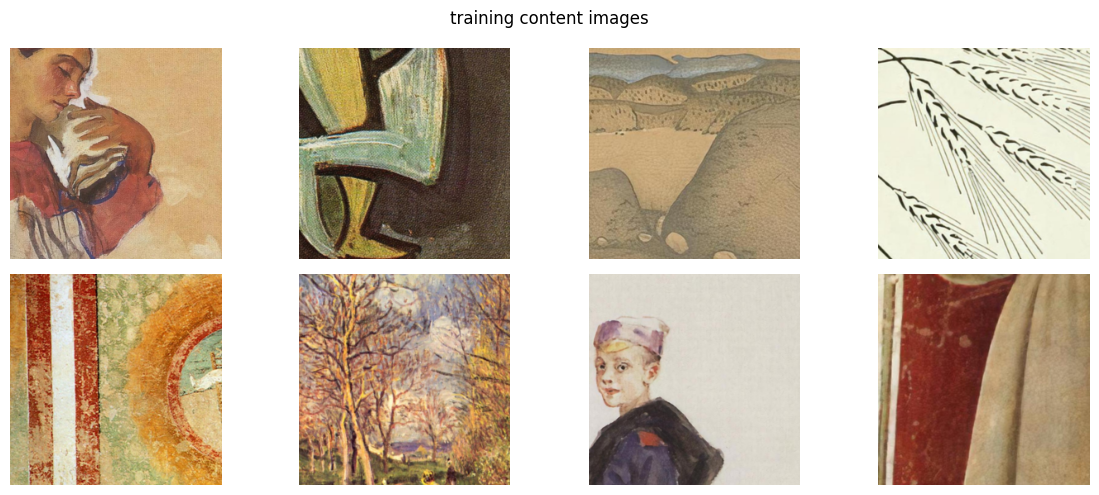

In [9]:
images = next(iter(train_style_dataloader))[:8]
labels = ["" for _ in range(len(images))]
show_images(images, labels, rows=2, title="training content images")

# MODEL

<img src="https://github.com/shoabahamed/Nueral-Style-Transfer-Models/blob/master/images/model_images/ArbitaryStyleTransfer/model_overview.png?raw=true" style="display:block; margin: auto" title="Model Overview">
<p style="text-align: center; margin-top:1rem">Figure:<a href="https://arxiv.org/abs/1703.06868"> <u>Model Overview</u></a></p>


We have three components a pretrained vgg19 encoder(weights are freezed during training), a AdaIn layer which transfer the statistics of style features to content features and a decoder which decode the feature maps to a stylized image. The training process can be summarized to-
1. Pass a content and style image to vgg encode to get the output of relu4_1 layer.
2. Transfer the feature map statistics of style image to contnet image feature maps
3. Take the stylized feature maps to generate a stylized image
4. Take the stylized image, content image and style image and pass them through the same vgg19 encoder to get the output feature maps of relu1_1, relu2_1, relu3_1 and relu4_1.
5. calculate the content loss and style loss and update the decoder parameters

# ENCODER
The encoder weights used are taken from [here](https://github.com/pietrocarbo/deep-transfer)

In [10]:
# the network structure of vgg19 till relu5_1 as we will at most need the relu5_1 output
enc_layers = nn.Sequential( 
    nn.Conv2d(3,3,(1, 1)),  # this is an extra preprocessing layer

    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3,64,(3, 3)),
    nn.ReLU(), # relu1_1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64,64,(3, 3)),
    nn.ReLU(), # relu1_2
    nn.MaxPool2d((2, 2),(2, 2),(0, 0)),

    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64,128,(3, 3)),
    nn.ReLU(), # relu2_1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128,128,(3, 3)),
    nn.ReLU(), # relu2_2
    nn.MaxPool2d((2, 2),(2, 2),(0, 0)),

    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128,256,(3, 3)),
    nn.ReLU(), # relu3_1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,256,(3, 3)),
    nn.ReLU(), # relu3_1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,256,(3, 3)),
    nn.ReLU(), # relu3_3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,256,(3, 3)),
    nn.ReLU(), # relu3_4

    nn.MaxPool2d((2, 2),(2, 2),(0, 0)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,512,(3, 3)),
    nn.ReLU(), # relu4_1
) 

class VGG_ENCODER(nn.Module):
    def __init__(self, model_path):
        super().__init__()
        
        self.relu1_1 = nn.Sequential(*enc_layers[:4])  # input -> relu1_1
        self.relu1_2 = nn.Sequential(*enc_layers[4:7]) # relu1_1 -> relu1_2
        self.relu2_1 = nn.Sequential(*enc_layers[7:11])  # relu1_2 -> relu2_1
        self.relu2_2 = nn.Sequential(*enc_layers[11:14]) # relu2_1 -> relu2_2
        self.relu3_1 = nn.Sequential(*enc_layers[14:18]) # relu2_2 -> relu3_1
        self.relu3_2 = nn.Sequential(*enc_layers[18:21]) # relu3_1 -> relu3_2
        self.relu3_3 = nn.Sequential(*enc_layers[21:24]) # relu3_3 -> relu3_3
        self.relu3_4 = nn.Sequential(*enc_layers[24:27]) # relu3_3 -> relu3_3
        self.relu4_1 = nn.Sequential(*enc_layers[27:31]) # relu3_4 -> relu4_1
        
        # loading pretrained vgg model weights
        enc_layers.load_state_dict(torch.load(model_path,map_location=CFG.device, weights_only=True))

        # Freeze the layers to prevent training them
        for param in self.parameters():
            param.requires_grad_(False)
            
        
        

    def forward(self, x):
        """
        x: (Batch_Size, Channels, Height, Width)
        output: dictionary containing the feature maps of all relu layers
        """
        output = {}
        
        x = self.relu1_1(x)
        output['relu1_1'] = x 
        
        x = self.relu1_2(x)
        
        x = self.relu2_1(x)
        output['relu2_1'] = x 
        
        x = self.relu2_2(x)
        
        x = self.relu3_1(x)
        output['relu3_1'] = x 

        x = self.relu3_2(x)
        x = self.relu3_3(x)
        x = self.relu3_4(x)
        
        x = self.relu4_1(x)
        output['relu4_1'] = x 
        
        
        return output


# DECODER 

The decoder is the inverse of vgg encoder

In [11]:
VGG_DECODER = nn.Sequential( # Sequential,
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,256,(3, 3)),
    nn.ReLU(),
    nn.UpsamplingNearest2d(scale_factor=2),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,256,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,256,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,256,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,128,(3, 3)),
    nn.ReLU(),
    nn.UpsamplingNearest2d(scale_factor=2),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128,128,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128,64,(3, 3)),
    nn.ReLU(),
    nn.UpsamplingNearest2d(scale_factor=2),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64,64,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64,3,(3, 3)),
)

# ADAIN

<img src="https://github.com/shoabahamed/Nueral-Style-Transfer-Models/blob/master/images/model_images/ArbitaryStyleTransfer/adain.png?raw=true" style="display:block; margin: auto" title="Model Overview">
<p style="text-align: center; margin-top:1rem">Figure:<a href="https://arxiv.org/abs/1703.06868"> <u>AdaIn</u></a></p>


Here x is content image feature map and y is style image feature map. We normalize the content feature maps by the mean and std of style feature maps. There is no trainable parameters in this layer

In [12]:
def AdaIN(content_features, style_features):
    """
        content_features: (B, C, H, W)
        styel_features: (B, C, H, W)
    """
    # content_mean: (B, C, 1, 1); content_std: (B, C, 1, 1)
    content_mean, content_std = calculate_mean_std(content_features)
    style_mean, style_std = calculate_mean_std(style_features)

    # normalizing the features
    normalized_content_features = (content_features - content_mean) / content_std
    return style_std * normalized_content_features + style_mean


def calculate_mean_std(features, eps=1e-5):
    """
    features: (B, C, H, W)
    """
    B, C, H, W = features.size()
    
    #(B, C, Height, Width) -> (B, C)
    feats_var = features.view(B, C, -1).var(dim=-1) + eps
    # (B, C) -> (B, C, 1, 1)
    feats_std = feats_var.sqrt().view(B, C, 1, 1)
    
    #(B, C, H, W) -> (B, C, 1, 1)
    feats_mean = features.view(B, C, -1).mean(dim=-1).view(B, C, 1, 1)
    
    return feats_mean, feats_std


The losses used in training the models is little different from fast neural style transfer model we have seen in the previous notebook

* Style Loss: Rather taking the l2 loss between the gram matrix of style feature maps and content features maps. We take the l2 loss between mean and std of feature maps which the authors have found to work better than gram matrix.  <i>See equation 13 in the paper</i>
* Content Loss: The content loss is the l2 loss between the stylized feature maps(output of adain layer)  and generated stylized images feature maps. <i>See equation 12 in the paper</i>

In [13]:
class Network(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder 
        self.decoder = decoder
        
        
    def forward(self, content_img, style_img, alpha=1.0):
        
        content_feature_maps = self.encoder(content_img)
        style_feature_maps = self.encoder(style_img)
        
        t = AdaIN(content_feature_maps['relu4_1'], style_feature_maps['relu4_1'])
        
        generated_img = self.decoder(t)
        generated_feature_maps = self.encoder(generated_img)
        
        content_loss = F.mse_loss(generated_feature_maps['relu4_1'], t)
        style_loss = 0.0
        for gen_feature_map, style_feature_map in zip(generated_feature_maps.values(), style_feature_maps.values()):
            style_loss += self.calculate_style_loss(gen_feature_map, style_feature_map)
            
        return content_loss, style_loss
    

    def stylize_image(self, content_img, style_img, alpha=0.5):
        content_feature_maps = self.encoder(content_img)
        style_feature_maps = self.encoder(style_img)
        
        t =  AdaIN(content_feature_maps['relu4_1'], style_feature_maps['relu4_1'])
        t = alpha * t + (1-alpha) * content_feature_maps['relu4_1']
        generated_img = self.decoder(t)
        
        return torch.clip(generated_img, 0.0, 1.0)
            

    def calculate_style_loss(self, gen_features, style_features):
        gen_mean, gen_std = calculate_mean_std(gen_features)
        style_mean, style_std = calculate_mean_std(style_features)

        return F.mse_loss(gen_mean, style_mean) + F.mse_loss(gen_std, style_std)


In [14]:
def plot_losses(losses, labels, axes, xlabel="batches", ylabel='loss'):
    """
    losses: a 2d list of losses
    labels: a list of the loss names
    axes: the axes to plot the losses
    """
     
    assert len(losses) == len(labels), "length of losses and labels do not match"
    assert len(labels) == len(axes), "length of losses and axes do not match"
    
    for loss, label, ax in zip(losses, labels, axes):
        plt.sca(ax)
        plt.plot(loss, label=label)
        plt.legend()
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    
def adjust_learning_rate(optimizer, no_iter):
    lr = CFG.learning_rate / (1.0 + CFG.lr_decay * no_iter)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
    return lr


def save_sample_stylized_images(model, sample_test_pairs, model_name, batches_done="last"):
    
    sample_content_img = sample_test_pairs[0]
    sample_style_img = sample_test_pairs[1]
    
    model.eval()
    with torch.no_grad():
        gen_img = model.stylize_image(sample_content_img, sample_style_img) 
        save_image(torch.cat([sample_content_img, sample_style_img, gen_img], dim=2), 
                   f"./{model_name}/images/validation_images/{batches_done}.jpg", nrow=4)
    model.train()
    

In [15]:
def training_loop(model_name, model, optimizer, train_content_dataloader, train_style_dataloader, sample_test_pairs, style_weight=10.0, 
                  checkpoint_model=None, evaluate_interval=None, checkpoint_interval=5000):
    
    print("Training model")
    seed_everything(CFG.seed)
    
    # creating directories for storing sample images and model checkpoints
    os.makedirs(f"./{model_name}/images/validation_images", exist_ok=True)
    os.makedirs(f"./{model_name}/checkpoints", exist_ok=True)
    
    # loading checkpoing model if exists
    if checkpoint_model:
        model.decoder.load_state_dict(torch.load(checkpoint_model, map_location=CFG.device, weights_only=True))
        print("Loaded checkpont decoder model")
    
    total_batches = CFG.max_iterations
    progress_bar = tqdm(total=total_batches, desc=f"batches done")
    train_content_batch_losses = []
    train_style_batch_losses = [] 
    mean_content_loss = 0.0
    mean_style_loss = 0.0
    start_time = time.time()

    train_content_iter =  iter(train_content_dataloader)
    train_style_iter =  iter(train_style_dataloader)
    model.train()
    for batch_id in range(total_batches):   
        adjust_learning_rate(optimizer, batch_id)
        
        optimizer.zero_grad()

        try:
            content_img = next(train_content_iter)
        except StopIteration:
            train_content_iter = iter(train_content_dataloader)
            content_img = next(train_content_iter)
        try:
            style_img = next(train_style_iter)
        except StopIteration:
            train_style_iter = iter(train_style_dataloader)
            style_img = next(train_style_iter)
        
        # move the images to appropiate devices and generate stylized images
        content_img = content_img.to(CFG.device)
        style_img =  style_img.to(CFG.device)

        
        content_loss, style_loss = model(content_img, style_img)
        style_loss = style_weight * style_loss
        loss = content_loss + style_loss
        loss.backward()
        
        norm = nn.utils.clip_grad_norm_(model.decoder.parameters(), max_norm=1.0) # clipping the gradient
        optimizer.step()


        train_style_batch_losses.append(style_loss.item())
        train_content_batch_losses.append(content_loss.item())
        mean_content_loss += content_loss.item() / evaluate_interval
        mean_style_loss += style_loss.item() / evaluate_interval
        batches_done = batch_id + 1 

        # saving the model at regular interval
        if checkpoint_interval > 0 and batches_done%checkpoint_interval == 0:
            torch.save(model.decoder.state_dict(), f"./{model_name}/checkpoints/{model_name}_decoder_{batches_done}.pth")

        # saving model output s at regular interval for 8 sample images
        if (evaluate_interval is not None and batches_done % evaluate_interval == 0):
            save_sample_stylized_images(model, sample_test_pairs, model_name, batches_done)
            end_time = time.time()
            train_time = end_time - start_time
            print(f"batches_ran: {batches_done} | " + f"time: {train_time/60:.4f} min | " +  
              f"train content loss: {mean_content_loss:.4f} | train style loss: {mean_style_loss:.4f} | " + 
              f"total loss: {mean_content_loss + mean_style_loss:.4f}")
            mean_content_loss = 0.0
            mean_style_loss = 0.0
            start_time = time.time()

        progress_bar.update(1)

            
    save_sample_stylized_images(model, sample_test_pairs, model_name, "last") 
    
    print(f"Trained model for {total_batches} iterations")
    print("Saving final model")
    torch.save(model.decoder.state_dict(), f"./{model_name}/checkpoints/{model_name}_decoder_last_checkpoint_{batches_done}.pth")
    return train_content_batch_losses, train_style_batch_losses

In [16]:
if CFG.train_model:
    vgg_encoder = VGG_ENCODER(CFG.encoder_path).to(CFG.device)
    vgg_decoder = VGG_DECODER.to(CFG.device)
    model = Network(vgg_encoder, vgg_decoder).to(CFG.device)
    optimizer = torch.optim.Adam(model.decoder.parameters(), lr=CFG.learning_rate)
    checkpoint_model = None

    sample_content_img = next(iter(valid_content_dataloader))[:4].to(CFG.device)
    sample_style_img = next(iter(valid_style_dataloader))[:4].to(CFG.device)
    sample_test_pairs = (sample_content_img, sample_style_img)
    style_weight = 10.0
    
    evaluate_interval = 10000
    checkpoint_iterval = 10000

    train_content_batch_losses, train_style_batch_losses = training_loop("adain_trained", model, optimizer, 
                                                                        train_content_dataloader, train_style_dataloader, sample_test_pairs,
                                                                        style_weight=style_weight, 
                                                                        checkpoint_model=checkpoint_model, evaluate_interval=evaluate_interval,
                                                                        checkpoint_interval=checkpoint_iterval)
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    plot_losses([train_content_batch_losses, train_style_batch_losses], ['content_losses', 'style_losses'], axes=axes, xlabel="iterations")
    plt.tight_layout()

# TESTING
I have already trained a decoder for 110000 iterations. The next cell loads the trained model weights

In [17]:
vgg_encoder = VGG_ENCODER(CFG.encoder_path).to(CFG.device)
vgg_decoder = VGG_DECODER.to(CFG.device)
model = Network(vgg_encoder, vgg_decoder).to(CFG.device)
optimizer = torch.optim.Adam(model.decoder.parameters(), lr=CFG.learning_rate)

model.decoder.load_state_dict(torch.load(CFG.trained_checkpoint_model, map_location=CFG.device, weights_only=True))

<All keys matched successfully>

In [18]:
# sample train images
seed_everything(1234563845)

train_content_dataset = FlatFolderDataset(train_content_paths, valid_transform)
train_style_dataset = FlatFolderDataset(train_style_paths, valid_transform)
train_content_dataloader = DataLoader(train_content_dataset, batch_size=CFG.batch_size, shuffle=True, pin_memory=True, drop_last=True)
train_style_dataloader = DataLoader(train_style_dataset, batch_size=CFG.batch_size, shuffle=True, pin_memory=True,  drop_last=True)



content_img = next(iter(train_content_dataloader))
style_img = next(iter(train_style_dataloader))

<img src="https://github.com/shoabahamed/Nueral-Style-Transfer-Models/blob/master/images/model_images/ArbitaryStyleTransfer/control_equation.png?raw=true" style="display:block; margin: auto" title="Model Overview">
<p style="text-align: center; margin-top:1rem">Figure:<a href="https://arxiv.org/abs/1703.06868"> <u>Control Stylization at run time</u></a></p>

In this model architecture we can control the amount of stylization by varying the value of alpha between 0 and 1. 1 means complete stylization and zero means no stylization at all. In the above equation-
* c = content image
* s = style iamge
* f(c) = content feature maps of relu4_1 layer
* f(s) = style features maps of relu4_1 layer


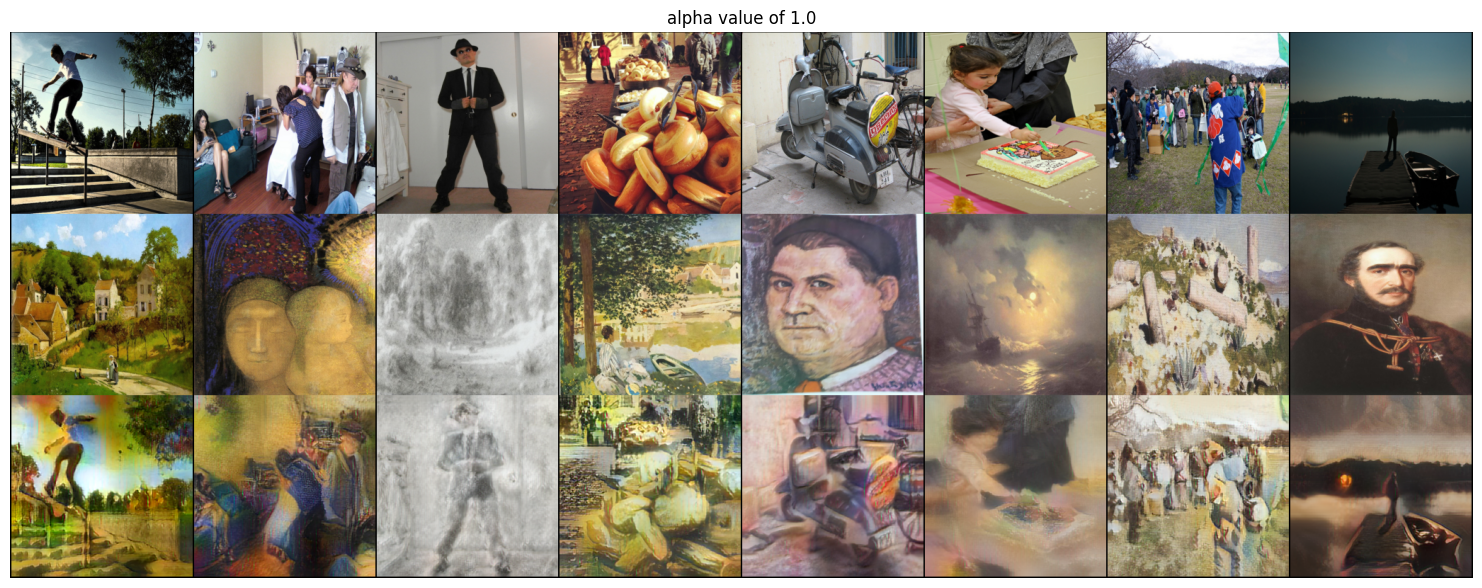

In [19]:
alpha = 1.0
model.eval()
with torch.no_grad():
    content_img = content_img.to(CFG.device)
    style_img = style_img.to(CFG.device)
    stylized_img = model.stylize_image(content_img, style_img, alpha=alpha)

images = make_grid(torch.cat([content_img, style_img, stylized_img], dim=2), nrow=8)

show_images(images.unsqueeze(0), labels=[f"alpha value of {alpha}"], rows=1, figsize=(15, 6))

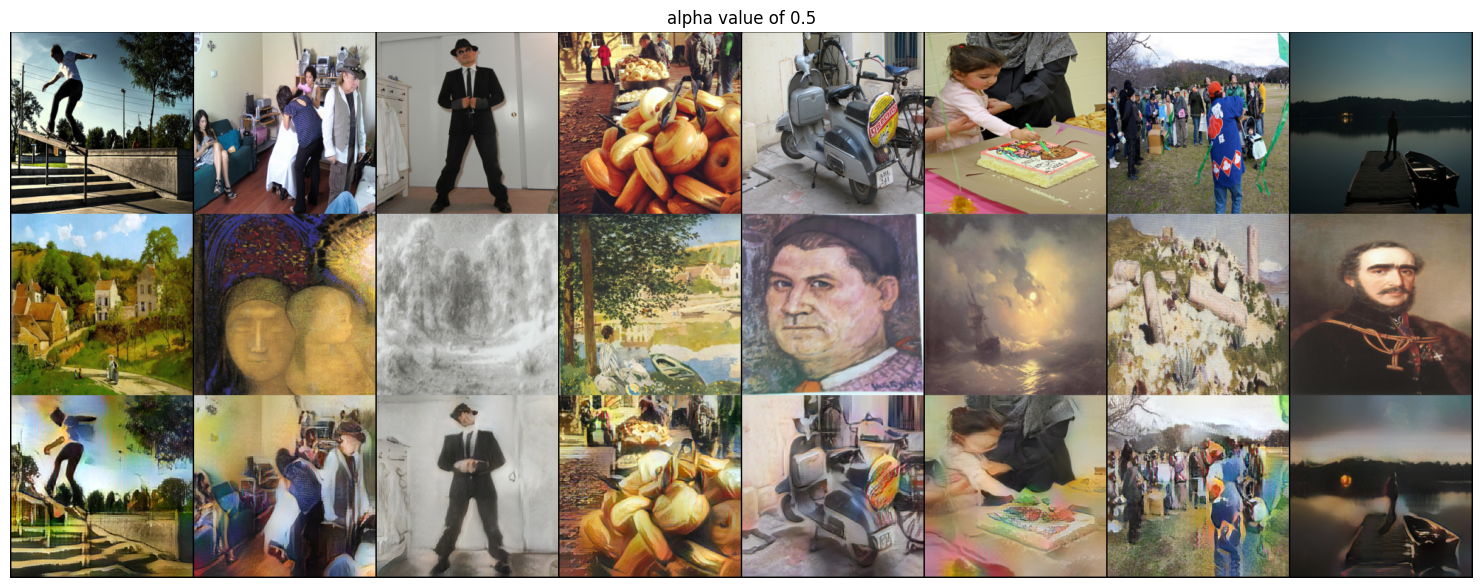

In [20]:
alpha = 0.5
model.eval()
with torch.no_grad():
    content_img = content_img.to(CFG.device)
    style_img = style_img.to(CFG.device)
    stylized_img = model.stylize_image(content_img, style_img, alpha=alpha)

images = make_grid(torch.cat([content_img, style_img, stylized_img], dim=2), nrow=8)

show_images(images.unsqueeze(0), labels=[f"alpha value of {alpha}"], rows=1, figsize=(15, 6))

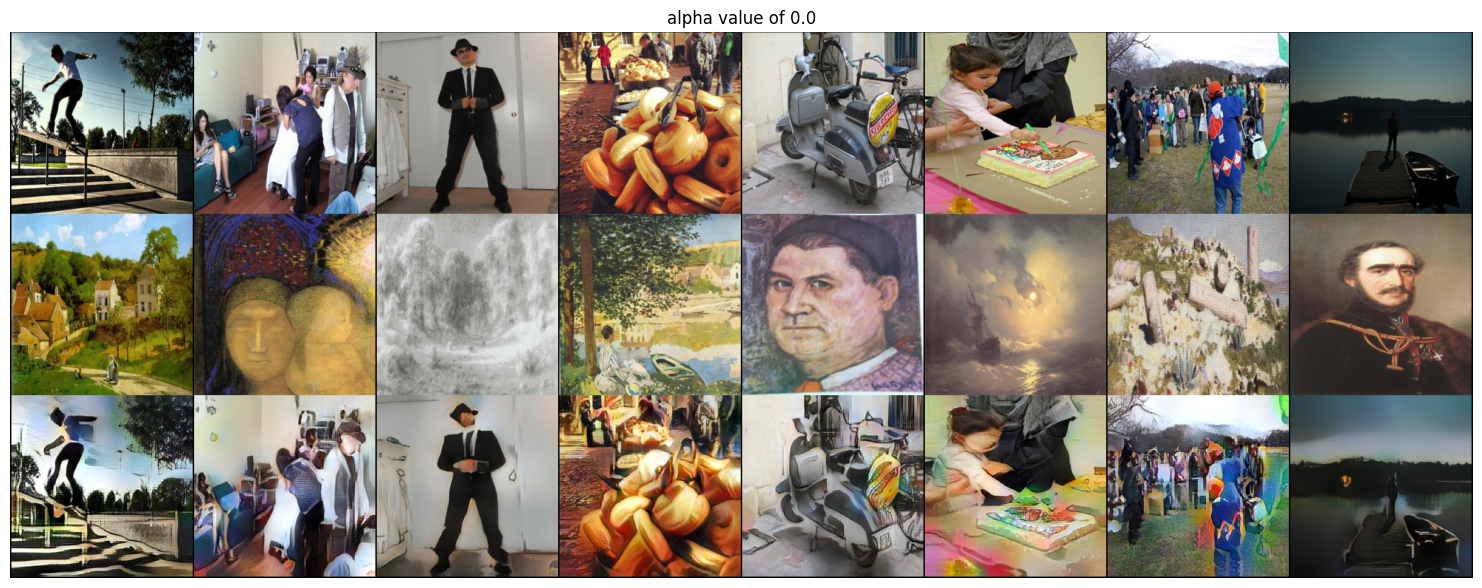

In [21]:
alpha = 0.0
model.eval()
with torch.no_grad():
    content_img = content_img.to(CFG.device)
    style_img = style_img.to(CFG.device)
    stylized_img = model.stylize_image(content_img, style_img, alpha=alpha)

images = make_grid(torch.cat([content_img, style_img, stylized_img], dim=2), nrow=8)

show_images(images.unsqueeze(0), labels=[f"alpha value of {alpha}"], rows=1, figsize=(15, 6))

# UNSEEN CONTENT IMAGE

In [22]:
# the line below loads a image to stylize
!wget -O content_img.jpg https://raw.githubusercontent.com/shoabahamed/Nueral-Style-Transfer-Models/master/images/example_content_images/small_room.jpg
# the line below downloads our style image
!wget -O style_img.jpg https://raw.githubusercontent.com/shoabahamed/Nueral-Style-Transfer-Models/master/images/example_style_images/edtaonisl.jpg

--2024-11-06 09:17:57--  https://raw.githubusercontent.com/shoabahamed/Nueral-Style-Transfer-Models/master/images/example_content_images/small_room.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 378622 (370K) [image/jpeg]
Saving to: 'content_img.jpg'

content_img.jpg     100%[===================>] 369.75K  --.-KB/s    in 0.02s   

2024-11-06 09:17:57 (23.6 MB/s) - 'content_img.jpg' saved [378622/378622]

--2024-11-06 09:17:58--  https://raw.githubusercontent.com/shoabahamed/Nueral-Style-Transfer-Models/master/images/example_style_images/edtaonisl.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|

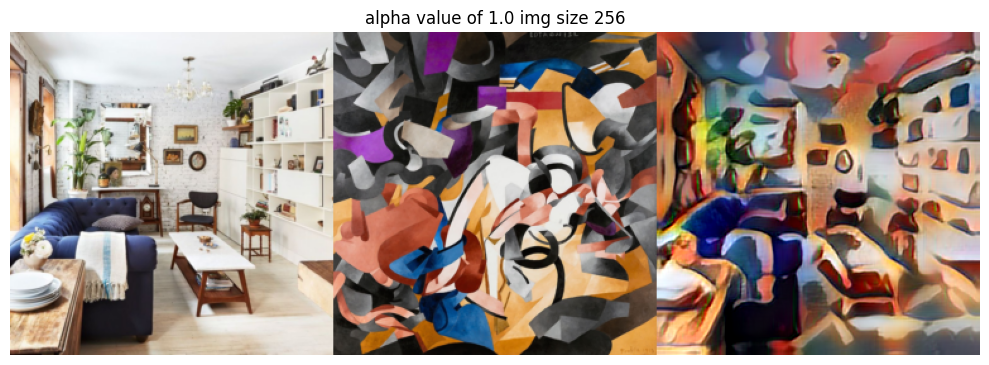

In [23]:
content_img_path = "/kaggle/working/content_img.jpg"
style_img_path = "/kaggle/working/style_img.jpg"

transform = get_transform(train=False, img_size=(256, 256))
content_img = transform(Image.open(content_img_path).convert("RGB")).unsqueeze(0)
style_img = transform(Image.open(style_img_path).convert("RGB")).unsqueeze(0)


alpha = 1.0
model.eval()
with torch.no_grad():
    content_img = content_img.to(CFG.device)
    style_img = style_img.to(CFG.device)
    stylized_img = model.stylize_image(content_img, style_img, alpha=alpha)

images = make_grid(torch.cat([content_img, style_img, stylized_img], dim=3), nrow=1)

show_images(images.unsqueeze(0), labels=[f"alpha value of {alpha} img size 256"], rows=1, figsize=(10, 5))

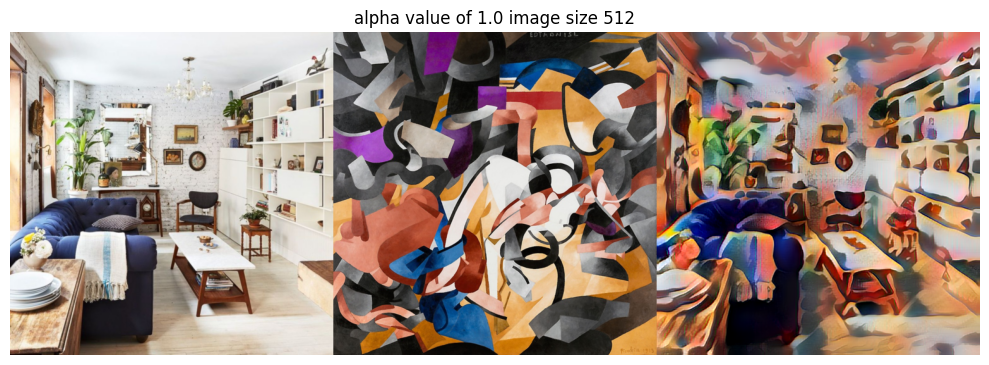

In [24]:
transform = get_transform(train=False, img_size=(512, 512))
content_img = transform(Image.open(content_img_path).convert("RGB")).unsqueeze(0)
style_img = transform(Image.open(style_img_path).convert("RGB")).unsqueeze(0)


alpha = 1.0
model.eval()
with torch.no_grad():
    content_img = content_img.to(CFG.device)
    style_img = style_img.to(CFG.device)
    stylized_img = model.stylize_image(content_img, style_img, alpha=alpha)

images = make_grid(torch.cat([content_img, style_img, stylized_img], dim=3), nrow=1)

show_images(images.unsqueeze(0), labels=[f"alpha value of {alpha} image size 512"], rows=1, figsize=(10, 5))

# KEY ACHIEVEMENTS & LIMITATIONS

We can see that through the model we can apply style transfer between any content and style image pair. The style transfer is also very fast and works well on images of different content image sizes. We can also control the amount of stylization at test time. But it also have some limitations

1. The model does not generalize weill to unseen style images and takes too long to train
2. The stylization quality is lower than fast style transfer we implemented previously and does not capture complicated styles very well


***The contribution of this paper is perhaps the fact that we can do style transfer by simply transfering the statistics of style image to content image simply. They did it through global mean and std and normalizing the feature maps***

# REFERENCES


* [Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization](https://arxiv.org/abs/1703.06868)
* [pytorch-AdaIN](https://github.com/naoto0804/pytorch-AdaIN)
* [Model Weights](https://github.com/pietrocarbo/deep-transfer)
* [Coco14](https://www.kaggle.com/datasets/jeffaudi/coco-2014-dataset-for-yolov3)
* [WikiArt](https://www.kaggle.com/datasets/steubk/wikiart)

# WHAT NEXT?

Although the arbitray style transfer works well as you can see the style transfer does not look that great. Main reason for this using only global mean and std to transfer the style which is ineffecient. In the next notebook we would implement the universal style transfer model which does style transfer by whitening and coloring an image